## Class Balance

In [24]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
import pickle

# %pip install pandas==1.4.1 --user

In [25]:
# read pickle file
with open('./sepsis_filled.pkl', 'rb') as f:
    sepsis_patients = pickle.load(f)
    
with open('./nonsepsis_filled.pkl', 'rb') as f:
    nonsepsis_patients = pickle.load(f)

In [26]:
# combine each patient's data into one record
sepsis_pred_filled = {}
nonsepsis_pred_filled = {}

for pid, data in sepsis_patients.items():
    if (data.empty):
        continue;
    sepsis_pred_filled[pid] = data.mean()
    sepsis_pred_filled[pid]['SepsisLabel'] = 1

for pid, data in nonsepsis_patients.items():
    if (data.empty):
        continue;
    nonsepsis_pred_filled[pid] = data.mean()
    nonsepsis_pred_filled[pid]['SepsisLabel'] = 0

In [29]:
# build data frame
df_sepsis = pd.concat(list(sepsis_pred_filled.values()), axis=1).transpose()
df_nonsepsis = pd.concat(list(nonsepsis_pred_filled.values()), axis=1).transpose()
df_all=pd.concat([df_sepsis, df_nonsepsis])
print('sepsis:', df_sepsis.shape[0], ', non-sepsis:', df_nonsepsis.shape[0], ', totle:', df_all.shape[0])
print('sick ratio:', df_all['SepsisLabel'].sum() / df_all['SepsisLabel'].shape[0])

sepsis: 2887 , non-sepsis: 37404 , totle: 40291
sick ratio: 0.07165371919287186


In [30]:
# define variable
X = df_all.drop(['SepsisLabel'], axis=1)
y = df_all['SepsisLabel']

In [53]:
# view 2-dimential
from sklearn.decomposition import PCA
def pca_draw(X, y): 
    pca = PCA(n_components=2)
    pca.fit(X)
    n_X = pca.transform(X)
    pos_X, neg_X = n_X[y==1], n_X[y==0]
    pos_X.shape, neg_X.shape

    plt.scatter(neg_X[:,0], neg_X[:,1], c='b', linewidths=0.2)
    plt.scatter(pos_X[:,0], pos_X[:,1], c='r', linewidths=0.2)

# print balance
def printBalance(before, after):
    print('before: n_pos = %d, n_neg = %d'%(np.sum(before==1), np.sum(before==0)))
    print('after: n_pos = %d, n_neg = %d'%(np.sum(after==1), np.sum(after==0)))

def save_2_pickle(var_X, var_y, pkl_name):
    var_set = var_X.copy(deep=True)
    var_set['SepsisLabel'] = var_y
    
    with open(pkl_name, 'wb') as f:
        pickle.dump(var_set, f)

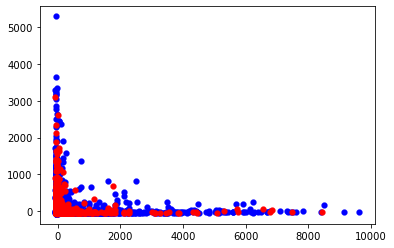

In [31]:
pca_draw(X, y)

In [32]:
# split set into training set and test set 7:3
from random import random
train_idx = np.array([1 if random()<0.7 else 0 for i in range(X.shape[0])])

train_X = X[train_idx==1]
train_y = y[train_idx==1]

test_X = X[train_idx==0]
test_y = y[train_idx==0]

print('Train set: n_pos = %d, n_neg = %d, ratio = %f'%(np.sum(train_y==1), np.sum(train_y==0), np.sum(train_y==1)/np.sum(train_y==0)))

Train set: n_pos = 2049, n_neg = 26101, ratio = 0.078503


In [54]:
# save to pkl
save_2_pickle(train_X, train_y, 'train_set.pkl')
save_2_pickle(test_X, test_y, 'test_set.pkl')

#### OverSampling: SMOTE

In [34]:
from imblearn.over_sampling import SMOTE

def smote(X, y, balanced_ratio=0.5):
    n_pos = int(np.sum(y==0)*balanced_ratio)
    model = SMOTE(sampling_strategy={1:n_pos})
    n_X, n_y = model.fit_resample(X, y)
    printBalance(y, n_y)
    return n_X, n_y

##### SMOTE balance ratio = 0.5

before: n_pos = 2049, n_neg = 26101
after: n_pos = 13050, n_neg = 26101


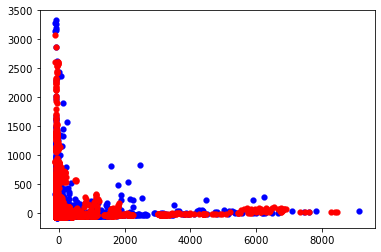

In [35]:
smote_X_0_5, smote_y_0_5 = smote(train_X, train_y, balanced_ratio=0.5)
pca_draw(smote_X_0_5, smote_y_0_5)

In [55]:
# save to pkl
save_2_pickle(smote_X_0_5, smote_y_0_5, 'smote_0_5.pkl')

##### SMOTE balance ratio = 1

before: n_pos = 2049, n_neg = 26101
after: n_pos = 26101, n_neg = 26101


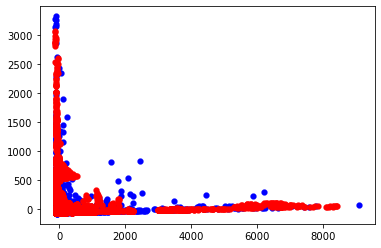

In [36]:
smote_X_1, smote_y_1 = smote(train_X, train_y, balanced_ratio=1)
pca_draw(smote_X_1, smote_y_1)

In [56]:
# save to pkl
save_2_pickle(smote_X_1, smote_y_1, 'smote_0_5.pkl')

#### DownSampling: TomekLinks

In [37]:
from imblearn.under_sampling import TomekLinks
def tomek(X, y):
#     n_pos = int(np.sum(y==0)*balanced_ratio)
    tl = TomekLinks(sampling_strategy='auto')
    X_res, y_res = tl.fit_resample(X, y)
    printBalance(y, y_res)
    return X_res, y_res

##### TomekLinks without SMOTE

before: n_pos = 2049, n_neg = 26101
after: n_pos = 2049, n_neg = 25958


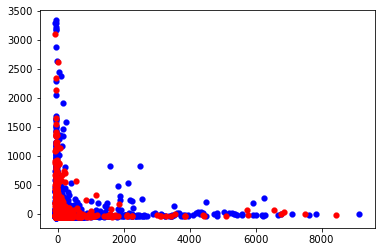

In [38]:
tomek_X, tomek_y = tomek(train_X, train_y)
pca_draw(tomek_X, tomek_y)

In [57]:
# save to pkl
save_2_pickle(tomek_X, tomek_y, 'tomek.pkl')

##### TomekLinks after SMOTE

before: n_pos = 26101, n_neg = 26101
after: n_pos = 26096, n_neg = 26101


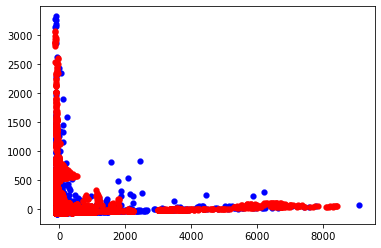

In [39]:
smote_tomek_X, smote_tomek_y = tomek(smote_X_1, smote_y_1)
pca_draw(smote_tomek_X, smote_tomek_y)

In [58]:
# save to pkl
save_2_pickle(smote_tomek_X, smote_tomek_y, 'smote_tomek.pkl')

#### DownSampling: Near Miss

In [40]:
from imblearn.under_sampling import NearMiss 
def near_miss(X, y):
    nm = NearMiss()
    X_res, y_res = nm.fit_resample(X, y)
    printBalance(y, y_res)
    return X_res, y_res

before: n_pos = 2049, n_neg = 26101
after: n_pos = 2049, n_neg = 2049


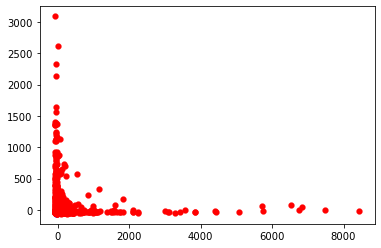

In [41]:
near_miss_X, near_miss_y = near_miss(train_X, train_y)
pca_draw(near_miss_X, near_miss_y)

In [59]:
# save to pkl
save_2_pickle(near_miss_X, near_miss_y, 'near_miss.pkl')

#### DownSampling: Edited Nearest Neighbours

In [42]:
from imblearn.under_sampling import EditedNearestNeighbours
def edit_nearest(X, y):
    enn = EditedNearestNeighbours()
    X_res, y_res = enn.fit_resample(X, y)
    printBalance(y, y_res)
    return X_res, y_res

before: n_pos = 2049, n_neg = 26101
after: n_pos = 2049, n_neg = 25174


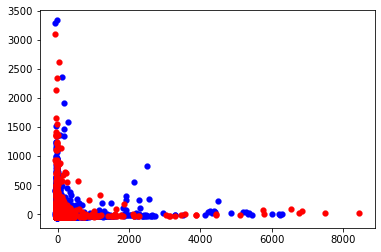

In [43]:
edit_nearest_X, edit_nearest_y = edit_nearest(train_X, train_y)
pca_draw(edit_nearest_X, edit_nearest_y)

In [60]:
# save to pkl
save_2_pickle(edit_nearest_X, edit_nearest_y, 'edit_nearest.pkl')